In [104]:
import sys
import os
sys.path.append("../../modules/")
import helper as hp
import matplotlib.pyplot as plt
%matplotlib inline
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.updates import *
from lasagne.objectives import *
from skimage.io import imread
from skimage import img_as_float

In [3]:
train_data, valid_data, test_data = hp.load_mnist("../../data/mnist.pkl.gz")

In [4]:
Xt, yt = train_data

In [5]:
Xt9 = Xt[ yt == 9 ]

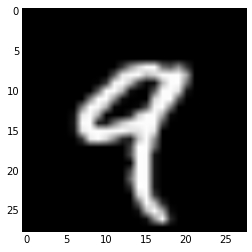

In [6]:
plt.imshow(Xt9[0][0], cmap="gray")

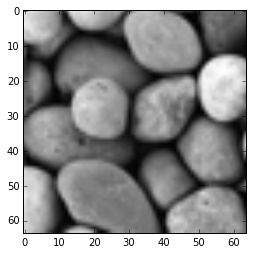

In [159]:
plt.imshow( img_as_float(imread("rocks2.png")), cmap="gray" )

In [164]:
rock = imread("rocks2.jpg") / 255.0
rock

array([[ 0.77254902,  0.76078431,  0.76078431, ...,  0.37647059,
         0.37647059,  0.3254902 ],
       [ 0.79215686,  0.72941176,  0.73333333, ...,  0.31764706,
         0.33333333,  0.29019608],
       [ 0.78039216,  0.7372549 ,  0.70980392, ...,  0.34509804,
         0.33333333,  0.30588235],
       ..., 
       [ 0.72156863,  0.70196078,  0.65490196, ...,  0.51764706,
         0.47058824,  0.32156863],
       [ 0.7254902 ,  0.70196078,  0.69803922, ...,  0.54901961,
         0.48627451,  0.34901961],
       [ 0.74509804,  0.67843137,  0.65882353, ...,  0.50196078,
         0.44705882,  0.34901961]])

In [165]:
rock = rock.reshape((1, 1, rock.shape[0], rock.shape[1]))

In [213]:
?MaxPool2DLayer

In [264]:
def conv_net(input_shape=(1,1,28,28), umin=0, umax=1):
    l_in = InputLayer(input_shape)
    l_conv1 = Conv2DLayer(l_in, num_filters=16, filter_size=(3,3))
    l_mp1 = Pool2DLayer(l_conv1, pool_size=(2,2), mode='average_inc_pad')
    l_conv2 = Conv2DLayer(l_mp1, num_filters=32, filter_size=(3,3))
    l_mp2 = Pool2DLayer(l_conv2, pool_size=(2,2), mode='average_inc_pad')
    #l_conv3 = Conv2DLayer(l_mp2, num_filters=64, filter_size=(3,3))
    #l_mp3 = Pool2DLayer(l_conv3, pool_size=(2,2), mode='average_inc_pad')
    #l_conv4 = Conv2DLayer(l_mp3, num_filters=64, filter_size=(3,3))
    #l_mp4 = Pool2DLayer(l_conv4, pool_size=(2,2), mode='average_inc_pad')
    l_out = l_mp2
    sys.stderr.write("number of params: %i\n" % count_params(l_out))
    outs = []
    X = T.tensor4('X')
    #Y = T.tensor4('Y')
    Y = theano.shared( np.random.uniform(umin, umax, size=input_shape ) )
    
    for layer in get_all_layers(l_out):
        # if the image is (bs, 1, f1, f2),
        # we want: (bs, 1*f1*f2) = (bs, f1*f2),
        # where f1 and f2 is the width/height of the feature map
        get_out = get_output(layer, X)
        outs.append( get_out.reshape( (get_out.shape[1], get_out.shape[2]*get_out.shape[3]) ) )
    
    loss_fn = 0
    for layer in get_all_layers(l_out):
        sys.stderr.write("%s,%s\n" % (str(layer), str(layer.output_shape)))
        if not isinstance(layer, Conv2DLayer):
            continue
        # compute the F matrix for actual image
        get_out_X = get_output(layer, X)
        get_out_X = get_out_X.reshape((get_out_X.shape[1], get_out_X.shape[2]*get_out_X.shape[3]) )
        # compute the F matrix for noisy image
        get_out_Y = get_output(layer, Y)
        get_out_Y = get_out_Y.reshape((get_out_Y.shape[1], get_out_Y.shape[2]*get_out_Y.shape[3]) )
        # (F_actual - F_noise)^2 then flatten then mean
        loss_fn += squared_error(
            T.dot(get_out_X.T, get_out_X), T.dot(get_out_Y.T, get_out_Y)
        ).flatten().mean()
    # (bs,1) + (bs,1) + ... + (bs,1)
    # then (bs,1).mean() = (1)
    #loss_fn = loss_fn.mean()
        
    updates = nesterov_momentum(loss_fn, get_all_params(l_out) + [Y], 0.01, 0.9)
    get_outs = theano.function([X], outs)
    train = theano.function([X], loss_fn, updates=updates)
    return {"get_outs": get_outs, "l_out": l_out, "train": train, "Y": Y}

In [265]:
cn = conv_net(Xt9[0:1].shape, umin=np.min(Xt9[0:1]), umax=np.max(Xt9[0:1]))

number of params: 4800
<lasagne.layers.input.InputLayer object at 0x11b638090>,(1, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x11b638510>,(1, 16, 26, 26)
<lasagne.layers.pool.Pool2DLayer object at 0x120fcee90>,(1, 16, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x11d35a690>,(1, 32, 11, 11)
<lasagne.layers.pool.Pool2DLayer object at 0x11d35a390>,(1, 32, 5, 5)


In [266]:
for i in range(0,50000):
    cn["train"](Xt9[0:1])

KeyboardInterrupt: 

In [267]:
i

3122

In [245]:
cn["train"](Xt9[0:1])

array(2.420927071977396e-05)

In [246]:
cn["Y"].get_value()[0][0].mean()

0.49611448559951937

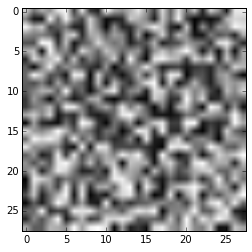

In [254]:
plt.imshow( cn["Y"].get_value()[0][0], cmap="gray", vmin=0, vmax=1 )

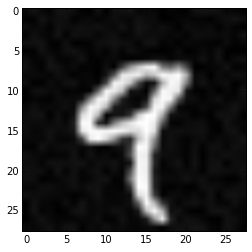

In [94]:
plt.imshow( cn["Y"].get_value()[0][0], cmap="gray" )

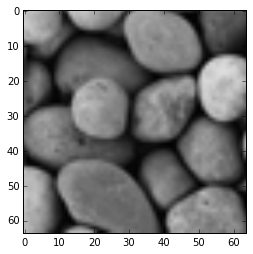

In [167]:
plt.imshow(rock[0][0], cmap="gray", vmin=0, vmax=1)

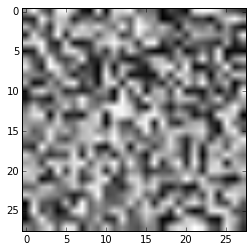

In [92]:
plt.imshow( cn["Y"].get_value()[0][0], cmap="gray" )

----

In [263]:
((cn["get_outs"](Xt9[0:1])[5] - cn["get_outs"](Xt9[1:2])[5])**2).shape

(64, 9)

In [131]:
((cn["get_outs"](Xt9[0:2])[1] - cn["get_outs"](Xt9[1:3])[1])**2).mean(axis=1)

array([ 0.00414589,  0.00216176])

In [114]:
((cn["get_outs"](Xt9[0:2])[0] - cn["get_outs"](Xt9[1:3])[0])**2).mean(axis=1).mean()

0.054249345039834779

In [133]:
get_output(cn["l_out"], theano.shared( np.zeros( (1,1,28,28) ) ) )

Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0

In [83]:
?Xt9.flatten()

In [181]:
np.dot( np.ones( (10, 20) ).T, np.ones( (10, 20) ) ).shape

(20, 20)